In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Exploring Latent Semantic Analysis in combination with tfidf Vectorizer to identify potential topics in *Emma* by Jane Austen.

# Preprocessing of the Text

In [2]:
!pip install nltk

In [3]:
import nltk
from nltk.corpus import gutenberg
nltk.download('gutenberg')
import re
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Kwasi\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [4]:
#reading in the data, this time in the form of paragraphs
nltk.download('punkt')
emma = gutenberg.paras('austen-emma.txt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kwasi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#reading in the data, this time in the form of paragraphs
emma=gutenberg.paras('austen-emma.txt')

#processing
emma_paras=[]
for paragraph in emma:
    para=paragraph[0]
    #removing the double-dash from all words
    para=[re.sub(r'--','',word) for word in para]
    #Forming each paragraph into a string and adding it to the list of strings.
    emma_paras.append(' '.join(para))

print(emma_paras[0:4])

['[ Emma by Jane Austen 1816 ]', 'VOLUME I', 'CHAPTER I', 'Emma Woodhouse , handsome , clever , and rich , with a comfortable home and happy disposition , seemed to unite some of the best blessings of existence ; and had lived nearly twenty - one years in the world with very little to distress or vex her .']


# tfidf Vectorizer in sklearn

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_train, X_test = train_test_split(emma_paras, test_size=0.4, random_state=0)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
emma_paras_tfidf=vectorizer.fit_transform(emma_paras)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(emma_paras_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Number of features: 1948
Original sentence: A very few minutes more , however , completed the present trial .
Tf_idf vector: {'minutes': 0.7127450310382584, 'present': 0.701423210857947}


# Dimension reduction
We will use Single Value Decomposition because we are dealing with a sparse matrix (which contains mainly zeroes and few non-zero values).

In [7]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 1379 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])


Percent variance captured by all components: 45.21525936059159
Component 0:
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !     0.999289
" Oh !"    0.999289
Name: 0, dtype: float64
Component 1:
" You have made her too tall , Emma ," said Mr . Knightley .                                                                                                                0.633809
" You get upon delicate subjects , Emma ," said Mrs . Weston smiling ; " remember that I am here . Mr .                                                                     0.572581
" I do not know what your opinion may be , Mrs . Weston ," said Mr . Knightley , " of this great intimacy between Emma and Harriet Smith , but I think it a bad thing ."    0.571473
" You are right , Mrs . Weston ," said Mr . Knightley warmly , " Miss Fairfax is as capable as any of us of forming a just opinion of Mrs . Elto

From scanning our most representative sample paragraphs, it appears that component 0 targets the exclamation 'Oh!', component 1 seems to largely involve critical dialogue directed at or about the main character Emma, component 2 is chapter headings, component 3 is exclamations involving 'Ah!, and component 4 involves actions by or directly related to Emma.



# Sentence similarity

We can also look at how similar various sentences are to one another.


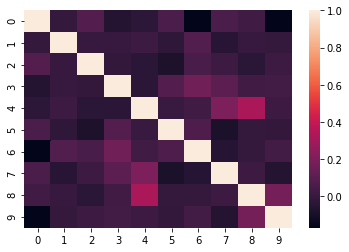

Key:
0 That is _court_ .
1 " Yes , sir , I did indeed ; and I am very much obliged by your kind solicitude about me ."
2 " How much his business engrosses him already is very plain from the circumstance of his forgetting to inquire for the book you recommended .
3 To restrain him as much as might be , by her own manners , she was immediately preparing to speak with exquisite calmness and gravity of the weather and the night ; but scarcely had she begun , scarcely had they passed the sweep - gate and joined the other carriage , than she found her subject cut up  her hand seized  her attention demanded , and Mr . Elton actually making violent love to her : availing himself of the precious opportunity , declaring sentiments which must be already well known , hoping  fearing  adoring  ready to die if she refused him ; but flattering himself that his ardent attachment and unequalled love and unexampled passion could not fail of having some effect , and in short , very much resolved on being

In [8]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

#Generating a key for the plot.
print('Key:')
for i in range(10):
    print(i,sim_matrix.index[i])



# Test set


In [9]:
# Remember, you will use the same model, only with the test set data.  Don't fit a new model by mistake!
X_test_lsa = lsa.transform(X_test_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_test_lsa,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Percent variance captured by all components: 45.21525936059159
Component 0:
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
" Oh !    0.999289
Name: 0, dtype: float64
Component 1:
" Well , Mrs . Weston ," said Emma triumphantly when he left them , " what do you say now to Mr . Knightley ' s marrying Jane Fairfax ?"                                                                                                                                                                                                                                                                                                                                                                          0.675637
Frank turned instantly to Emma , to claim her former promise ; and boasted himself an engaged man , which his father looked his most perfect approbation of  and it then appeared that Mrs . W

# Tweaking tf-idf


In [10]:
!pip install spacy

In [11]:
import spacy

In [12]:
emma_txt = gutenberg.raw('austen-emma.txt')
nlp = spacy.load("en_core_web_sm")

In [14]:
nlp = spacy.load('en_core_web_sm')
emma_paras_new = []
for entry in emma_paras:
    emma_paras_new.append(nlp(entry))

In [15]:
emma_paras_lemmas = []
for entry in emma_paras:
    entry_parsed = nlp(entry)
    string = ''
    for token in entry_parsed:
        if not token.is_punct:
            string += token.lemma_ + ' '
    emma_paras_lemmas.append(string)

In [16]:
#Applying the vectorizer
emma_paras_lemmas_tfidf=vectorizer.fit_transform(emma_paras_lemmas)
print("Number of features: %d" % emma_paras_tfidf.get_shape()[1])

Number of features: 1948


In [17]:
X_train, X_test = train_test_split(emma_paras_lemmas, test_size=0.4, random_state=0)
X_train_lemmas_tfidf, X_test_lemmas_tfidf= train_test_split(emma_paras_lemmas_tfidf, test_size=0.4, random_state=0)

In [18]:
X_train_lemmas_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.42224995,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [19]:
X_train_lsa_lemmas = lsa.fit_transform(X_train_lemmas_tfidf)

variance_explained_lemmas=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)


Percent variance captured by all components: 45.21525936059159


In [20]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa_lemmas,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
oh     0.999107
Name: 0, dtype: float64
Component 1:
-PRON- do not know what -PRON- opinion may be Mrs Weston say Mr Knightley of this great intimacy between Emma and Harriet Smith but -PRON- think -PRON- a bad thing                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [21]:
#Tweaks Go Here
vectorizer_one = TfidfVectorizer(max_df=0.6, # drop words that occur in more than half the paragraphs
                             min_df=30, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [22]:
#Applying the vectorizer
emma_paras_lemmas_tfidf_one=vectorizer_one.fit_transform(emma_paras_lemmas)
print("Number of features: %d" % emma_paras_lemmas_tfidf_one.get_shape()[1])

Number of features: 100


In [23]:
X_train_lemmas_tfidf_one, X_test_lemmas_tfidf_one= train_test_split(emma_paras_lemmas_tfidf_one, test_size=0.4, random_state=0)

In [24]:
svd_one= TruncatedSVD(50)
lsa_one = make_pipeline(svd_one, Normalizer(copy=False))

In [25]:
X_train_lsa_lemmas_one = lsa_one.fit_transform(X_train_lemmas_tfidf_one)

variance_explained_lemmas=svd_one.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 45.21525936059159


In [26]:
paras_by_component=pd.DataFrame(X_train_lsa_lemmas_one,index=X_train)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
Mrs Weston be act no part feign no feeling in all that -PRON- say to -PRON- in favour of the event -PRON- have be extremely surprize never more so than when Emma first open the affair to -PRON- but -PRON- see in -PRON- only increase of happiness to all and have no scruple in urge -PRON- to the utmost -PRON- have such a regard for Mr Knightley as to think -PRON- deserve even -PRON- dear Emma and -PRON- be in every respect so proper suitable and unexceptionable a connexion and in one respect one point of the high importance so peculiarly eligible so singularly fortunate that now -PRON- seem as if Emma could not safely have attach -PRON- to any other creature and that -PRON- have -PRON- be the stupid of being in not have thought of -PRON- and wish -PRON- long ago how very few of those man in a rank of life to address Emma would have renounce -PRON- own home for Hartfield     0.753409
emma say Mr Knightley presently -PRON- have a piece of news for -PRON-                       

# Test Set Components

In [27]:
X_test_lsa_lemmas_one = lsa_one.transform(X_test_lemmas_tfidf_one)

In [28]:
paras_by_component=pd.DataFrame(X_test_lsa_lemmas_one,index=X_test)
for i in range(5):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])

Component 0:
read -PRON- read -PRON- say -PRON- -PRON- will give -PRON- pleasure only a few line   will not take -PRON- long read -PRON- to Emma                                                                                                      0.709129
well Mrs Weston say Emma triumphantly when -PRON- leave -PRON- what do -PRON- say now to Mr Knightley s marry Jane Fairfax                                                                                                               0.692716
well say Emma there be no dispute about taste at least -PRON- admire -PRON- except -PRON- complexion                                                                                                                                     0.690775
nobody have any information to give and after a few more wondering Emma say                                                                                                                                                              0.690775
but -PRON- laugh so

## Components Identified:

- component 0: Emma's utternaces
- component 1: 'oh' interjection
- component 2: Emma's inner thoughts and her emotions
- component 3: dialogue between Emma and a male characters
- component 4: Anything related to harriet


Intresting what you could do with text after you start to be able to parse out from a corpus. This type of clustering could be useful in figuring the topics of a book, a chapter, a podcast, etc. Then the next thing you could do is work those topics into classifications. This is among the many other things this could help with. 